# COVID-19 Tweets Sentiment Analysis
### By: Andrej Pozderac, Andrew Edward, Faaiz Joad
# -----------------------------------------------------------------------------


# * Table of Contents
### 1. Introduction and Motivation
### 2. Data Collection
### 3. Data Cleaning and Processing
### 4. Data Analysis and Modeling
### 5. Conclusion

## 1. Introduction & Motivation

The SARS-CoV-2 has for the past year caused much difficulty and damage throughout the world. As of now, specifically in the United States - there have been over 13 million cases confirmed, with more than 150k new cases identified each day. Given the amount of glaring examples of people reacting in all sorts of ways to Covid-19, with protests against masks and outright declarations of it being a hoax, what really is the overall impression of people in the U.S. on the virus? Moreover, with the spread of "fake news" and the possibilities of such ideas floating about more rapidly with the lockdown and longer access to social media - has this had an effect peoples' perception in the United States? In other words, have peoples' opinions changed at all throughout the pandemic, and in what ways? These were the initial questions we asked ourselves while discussing the topic.

Motivation:

Our scope for the analysis broadened and we set on trying to understand and predict peoples' veiws on the virus depending on their social media interactions, specifically from their tweets. This was motivated further by two questions of "If there is a case of a significant amount of people not believing in the virus - is this more prominent in some places and why is that so?". To do so, we set out a series of goals in forms of analysis and modeling, building towards the sentiment analysis for predicted their opinions and opinion changes. Our goals were as follows:
		-Analysis of the sentiment of tweets regarding the virus
		-Understanding differences in word usage of "corona" and "Covid-19"
		-A time series analysis on previous points, observing the changes over time
		-Predicting which words could lead to a person having a specific sentiment (positive, negative)
		-Preparing Word Clouds and Bigrams to show the interconnectedness of words within sentiments
		-*Utilizing the previous points to build our own dictionaries for detecting more specific sentiment (believes, doesn't believe)
		-*Predicting a persons' opinion towards the virus from their tweets

While we have managed to make good progress in the goals, we have set for ourselves, we did not reach the full extent of our motivated work. We hope to keep working on this project and cover the last two points (marked with *) to see our scope to fruition. Moreover, we further hope to gain access to more specific location of tweets to answer our further motivations of state-by-state analyses and the possibility of our model being used in national decision making.

In [1]:
import pandas as pd
import re
import nltk
import collections
import string
import numpy as np
import sklearn
import gzip
import csv
import matplotlib.pyplot as plt
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.models import Word2Vec
from time import time
from nltk import bigrams
import itertools
import collections
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import networkx as nx
from wordcloud import WordCloud
from textblob import TextBlob
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
# from plotnine import *
# from plotnine.data import *
import plotly as py
import plotly.express as px
import pyLDAvis.sklearn

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

## 2. Data Collection
To collect tweets from older months, we could not use the Twitter API free version because it only acquires tweets in the past seven days.
And since Twitter launched V2 of its API this September and retired the old one, all libraries and work-arounds were no longer an option.
So to collect our data we used snscrape: https://github.com/JustAnotherArchivist/snscrape  
A scraper for social networking services (SNS). With it, we scrapped Twitter's search page, which returns a lot of any time you choose but does not return everything.
This is a limitation for the paper but we just used this data to explore all sorts of analysis that we can do if we had access to the premium API.

We created a list of keywords, mostly focusing on "Covid-19" and "Corona" to retrieve all tweets using snscrape.
For every tweet, we collected the date, text and if the person who tweeted used COVID-19 or Corona when talking about the virus.

Moreover, all tweets retrieved are from the United States of America.

Tweets collected were around 25,000 tweets from 1st of March 2020 to 30th of November 2020

In [2]:
covid_19_tweets = pd.read_csv('final_tweets.csv')

In [3]:
covid_19_tweets

,Date,Tweet,User,Keyword
0,11/26/2020,OlgaNYC1211 Me Hello FBI and DHSgov Id like to...,HereNowForever1,COVID
1,11/26/2020,gilliland1tide Must have been a contest of the...,profstan72,COVID
2,11/26/2020,I invented a diet called the Chimp Diet You ea...,blackbettyblog,corona
3,11/26/2020,People have told youll find the one someday So...,GravityOcean13,corona
4,11/26/2020,I havent seen mfs in a while This COVID19 fuck...,In_Jay_We_Trust,COVID
...,...,...,...,...
25822,03/01/2020,People its CoronaVirus or COVID19 Pick one Als...,_lydiamj,COVID
25823,03/01/2020,swkoti Rice Pasta Canned soup Getting ready fo...,babybellarose,COVID
25824,03/01/2020,Theyre chasing me the journalist who wouldnt s...,amici09,COVID
25825,03/01/2020,Calling it now it will be the 2021 Summer Olym...,kraichdm,COVID


## 3. Data cleaning and processing
To clean the data, we created a function that made sure to clean every tweet from hyperlinks and stopwords while also tokenzing and lemmatizing every tweet text so we would able to look at these words.

In [4]:
covid_19_tweets['Date'] = covid_19_tweets['Date'].apply(lambda row: row.split('/')[0])
covid_19_tweets

,Date,Tweet,User,Keyword
0,11,OlgaNYC1211 Me Hello FBI and DHSgov Id like to...,HereNowForever1,COVID
1,11,gilliland1tide Must have been a contest of the...,profstan72,COVID
2,11,I invented a diet called the Chimp Diet You ea...,blackbettyblog,corona
3,11,People have told youll find the one someday So...,GravityOcean13,corona
4,11,I havent seen mfs in a while This COVID19 fuck...,In_Jay_We_Trust,COVID
...,...,...,...,...
25822,03,People its CoronaVirus or COVID19 Pick one Als...,_lydiamj,COVID
25823,03,swkoti Rice Pasta Canned soup Getting ready fo...,babybellarose,COVID
25824,03,Theyre chasing me the journalist who wouldnt s...,amici09,COVID
25825,03,Calling it now it will be the 2021 Summer Olym...,kraichdm,COVID


In [5]:
def clean_tweet(tweet):
    #Step 1 - drop links
    regex = re.compile(r'https?://t.co/[a-zA-Z0-9]{10}')
    remove_links = re.split(regex,tweet)
    remove_links = ' '.join(remove_links)
    #Step 2 - Remove any non-ascii characters
    remove_non_ascii =  re.sub(r'[^\x00-\x7F]+',' ', remove_links).lower()

    #Step 3 - check for apostrophes
    remove_apostroph = remove_non_ascii.replace("'s","")
    remove_apostroph = remove_apostroph.replace("'","")
    remove_apostroph = remove_apostroph.split(' ')
    #Step 4 - Remove dashes
    remove_dashes = ' '.join(remove_apostroph).split('-')
    remove_dashes = ' '.join(remove_dashes)

    #Step 5 - Keep letters and digits only
    keep_letters =  re.sub(r'[^a-zA-Z0-9]',' ', remove_dashes)

    keep_letters = keep_letters.split(' ')

    keep_letters = ' '.join(keep_letters)

    #Step 6 - Tokenize 
    tokenize = nltk.word_tokenize(keep_letters)

    #Step 7 - Lemmatize    
    lemmatizer= nltk.stem.wordnet.WordNetLemmatizer()
    lemmatize_text = map(lambda x: lemmatizer.lemmatize(x), tokenize)
    print(list(lemmatize_text))

    #Step 8 - Remove stop words
    stopwords = set(nltk.corpus.stopwords.words('english'))
    remove_stop = list(filter(lambda x: x not in stopwords, lemmatize_text))

    #Step 9 - Remove any empty strings from list
    processed_list = list(filter(lambda a: a != "", remove_stop))

    processed_string = " ".join(processed_list)

    return processed_string

In [6]:
lemmatizer=nltk.stem.wordnet.WordNetLemmatizer()
lemmatizer.lemmatize("striped")

'striped'

In [7]:
clean_tweet(covid_19_tweets['Tweet'][2450])

['covid19', 'ha', 'killed', 'well', 'over', 'million', 'american', 'and', 'is', 'still', 'getting', 'worse', 'i', 'cant', 'help', 'but', 'wonder', 'how', 'many', 'people', 'are', 'going', 'to', 'have', 'their', 'last', 'thanksgiving', 'dinner', 'tomorrow', 'because', 'they', 'stubbornly', 'decided', 'that', 'tradition', 'is', 'more', 'important', 'than', 'health', 'and', 'common', 'sense']


''

In [18]:
covid_19_tweets['Tweet'] = covid_19_tweets['Tweet'].apply(lambda x: clean_tweet(x))

In [19]:
def sent_to_list(sentence):
    return sentence.split(" ")

In [20]:
covid_19_tweets['words_list'] = covid_19_tweets['Tweet'].apply(lambda x: sent_to_list(x))

In [21]:
covid_19_tweets_3 = covid_19_tweets.loc[covid_19_tweets['Date'] == '03']
covid_19_tweets_4 = covid_19_tweets.loc[covid_19_tweets['Date'] == '04']
covid_19_tweets_5 = covid_19_tweets.loc[covid_19_tweets['Date'] == '05']
covid_19_tweets_6 = covid_19_tweets.loc[covid_19_tweets['Date'] == '06']
covid_19_tweets_7 = covid_19_tweets.loc[covid_19_tweets['Date'] == '07']
covid_19_tweets_8 = covid_19_tweets.loc[covid_19_tweets['Date'] == '08']
covid_19_tweets_9 = covid_19_tweets.loc[covid_19_tweets['Date'] == '09']
covid_19_tweets_10 = covid_19_tweets.loc[covid_19_tweets['Date'] == '10']
covid_19_tweets_11 = covid_19_tweets.loc[covid_19_tweets['Date'] == '11']
covid_19_tweets_11

,Date,Tweet,User,Keyword,words_list
0,11,olganyc1211 hello fbi dhsgov id like report ac...,HereNowForever1,COVID,"[olganyc1211, hello, fbi, dhsgov, id, like, re..."
1,11,gilliland1tide must contest three worst disast...,profstan72,COVID,"[gilliland1tide, must, contest, three, worst, ..."
2,11,invented diet called chimp diet eat mostly fru...,blackbettyblog,corona,"[invented, diet, called, chimp, diet, eat, mos..."
3,11,people told youll find one someday like whens ...,GravityOcean13,corona,"[people, told, youll, find, one, someday, like..."
4,11,havent seen mf covid19 fucked link,In_Jay_We_Trust,COVID,"[havent, seen, mf, covid19, fucked, link]"
...,...,...,...,...,...
22583,11,roxymojo please listen vet also doctor fightin...,Frodo60,COVID,"[roxymojo, please, listen, vet, also, doctor, ..."
22584,11,beschlossdc please listen vet also doctor figh...,Frodo60,COVID,"[beschlossdc, please, listen, vet, also, docto..."
22585,11,jerry deli studio city close friday covid19 fa...,needcollegehelp,COVID,"[jerry, deli, studio, city, close, friday, cov..."
22586,11,urocklive1 johnwdean please listen vet also do...,Frodo60,COVID,"[urocklive1, johnwdean, please, listen, vet, a..."


In [22]:
covid_19_tweets

,Date,Tweet,User,Keyword,words_list
0,11,olganyc1211 hello fbi dhsgov id like report ac...,HereNowForever1,COVID,"[olganyc1211, hello, fbi, dhsgov, id, like, re..."
1,11,gilliland1tide must contest three worst disast...,profstan72,COVID,"[gilliland1tide, must, contest, three, worst, ..."
2,11,invented diet called chimp diet eat mostly fru...,blackbettyblog,corona,"[invented, diet, called, chimp, diet, eat, mos..."
3,11,people told youll find one someday like whens ...,GravityOcean13,corona,"[people, told, youll, find, one, someday, like..."
4,11,havent seen mf covid19 fucked link,In_Jay_We_Trust,COVID,"[havent, seen, mf, covid19, fucked, link]"
...,...,...,...,...,...
25822,03,people coronavirus covid19 pick one also yall ...,_lydiamj,COVID,"[people, coronavirus, covid19, pick, one, also..."
25823,03,swkoti rice pasta canned soup getting ready co...,babybellarose,COVID,"[swkoti, rice, pasta, canned, soup, getting, r..."
25824,03,theyre chasing journalist wouldnt stay quiet c...,amici09,COVID,"[theyre, chasing, journalist, wouldnt, stay, q..."
25825,03,calling 2021 summer olympics olympics tokyo co...,kraichdm,COVID,"[calling, 2021, summer, olympics, olympics, to..."


## 4. Data Analysis & Modeling
### 4.1 Word Cloud

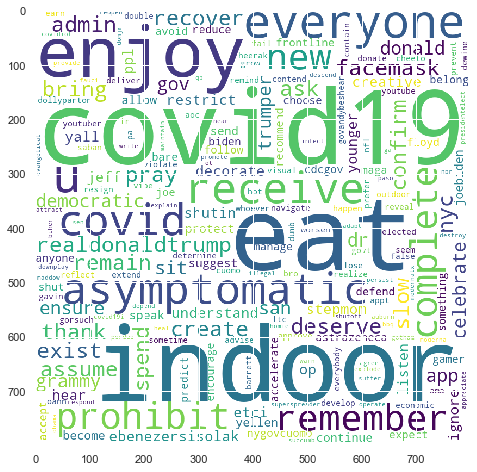

In [23]:
words_covid = list(itertools.chain(*covid_19_tweets['words_list'].tolist()))

counts_words = collections.Counter(words_covid)

wc = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                min_font_size = 10).generate(" ".join(counts_words)) 
                
plt.figure(figsize=(10,8))
plt.imshow(wc)

### 4.2 Frequency of words

In [24]:
def check_word(word):
    if len(word) > 2:
        return word
    else:
        return "x"

In [25]:
words_covid_df = pd.DataFrame(columns = ['words'])
words_covid_df['words'] = words_covid

words_covid_df = words_covid_df['words'].value_counts(sort=True).to_frame().reset_index().rename(columns={'words':'occurences','index': 'words'})
words_covid_df = words_covid_df[words_covid_df['words'] != "covid19"]
words_covid_df = words_covid_df[words_covid_df['words'] != "corona"]
words_covid_df = words_covid_df[words_covid_df['words'] != "covid"]
words_covid_df = words_covid_df[words_covid_df['words'] != "coronavirus"]

words_covid_df['words'] = words_covid_df['words'].apply(lambda x: check_word(x))
words_covid_df = words_covid_df[words_covid_df['words'] != "x"]
words_covid_df = words_covid_df.head(30)
word_occurences = px.bar(x = words_covid_df['words'], 
                    y = words_covid_df['occurences'],
                    title = '', 
                    labels = dict(x = 'Words', y = 'Number of tweets'),
                    color = words_covid_df['words'])
                    
word_occurences.show()

### 4.3 Sentiment over time
### 4.3.1 Polarity chart

In [26]:
sentiment_objects = [TextBlob(tweet) for tweet in covid_19_tweets]

25827
[-0.11964285714285713, 'olganyc1211 hello fbi dhsgov id like report activated domestic terrorist cell namely catholic church america bioterrorism mass murder mean unchecked covid19 large gathering weaponized supreme court yes ill hold']


Text(0.5, 0, 'Polarity')

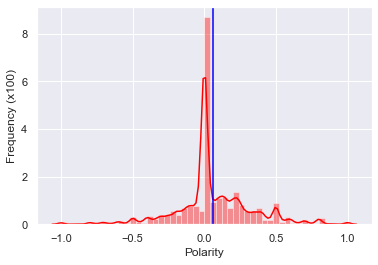

In [27]:
import plotly.figure_factory as ff

sentiment_objects = [TextBlob(tweet) for tweet in covid_19_tweets['Tweet']]

all_sentiment = [tweet.sentiment.polarity for tweet in sentiment_objects]
pos_counter = 0
neg_counter = 0
neu_counter = 0

print(len(covid_19_tweets))

sentiment_values = [[tweet.sentiment.polarity, str(tweet)] for tweet in sentiment_objects]
print(sentiment_values[0])
# Create dataframe containing the polarity value and tweet text

sentiment_df = pd.DataFrame(sentiment_values, columns=["polarity", "tweet"])
# sentiment_df = sentiment_df[sentiment_df.polarity != 0]
#print(sentiment_df)
x = sentiment_df['polarity'].values # array with polarity only

sns.distplot(x, color = 'red');

# Calculating the mean
mean = sentiment_df['polarity'].mean()

#ploting the mean
plt.axvline(mean, 0,1, color = 'blue')

plt.ylabel("Frequency (x100)")
plt.xlabel("Polarity")

In this figure, we wanted to understand the sentiment distribution in tweets in the US. As we can see, most of the sentiment is very neutral, which can be attributed to a substantial amount of tweets that were from sources that are not personal accounts, and represent corporate or news point of view.

Another research paper that examines sentiment over tweets that we looked at also produces similar results when it comes to distribution sentiment, which makes us confident in this result even though the sample of tweets was not as large as we expected.

In [28]:
sentiment_df

,polarity,tweet
0,-0.119643,olganyc1211 hello fbi dhsgov id like report ac...
1,-1.000000,gilliland1tide must contest three worst disast...
2,0.283333,invented diet called chimp diet eat mostly fru...
3,-0.200000,people told youll find one someday like whens ...
4,-0.600000,havent seen mf covid19 fucked link
...,...,...
25822,0.000000,people coronavirus covid19 pick one also yall ...
25823,0.200000,swkoti rice pasta canned soup getting ready co...
25824,0.000000,theyre chasing journalist wouldnt stay quiet c...
25825,0.000000,calling 2021 summer olympics olympics tokyo co...


In [29]:
neg = sentiment_df['polarity'].astype('float')
neg = neg[neg <= -0.1]
neg

0       -0.119643
1       -1.000000
3       -0.200000
4       -0.600000
19      -0.600000
           ...   
25771   -0.600000
25774   -0.208333
25776   -0.100000
25806   -0.375000
25815   -0.130000
Name: polarity, Length: 4561, dtype: float64

In [30]:
pos = sentiment_df['polarity'].astype('float')
pos = pos[pos >= 0.1]
pos

2        0.283333
6        0.197857
7        0.350000
8        0.150000
9        0.380000
           ...   
25819    0.200000
25820    0.250000
25821    0.166667
25823    0.200000
25826    0.166667
Name: polarity, Length: 9317, dtype: float64

In [31]:
neutrals = sentiment_df['polarity'].astype('float')
neutrals = neutrals[neutrals < 0.1]
neutrals = neutrals[neutrals > -0.1]
neutrals

5        0.000000
10       0.000000
14       0.000000
17       0.000000
20       0.000000
           ...   
25810    0.066667
25814    0.000000
25822    0.000000
25824    0.000000
25825    0.000000
Name: polarity, Length: 11949, dtype: float64

In [32]:
def polarity_category(pol):
    if (pol < 0.1 and pol > -0.1):
        return "neutral"
    if pol >= 0.1:
        return "positive"
    if pol <= -0.1:
        return "negative"

In [33]:
covid_19_tweets['sentiment_pol'] = sentiment_df['polarity']
covid_19_tweets['sentiment_pol'] = covid_19_tweets['sentiment_pol'].apply(lambda x: polarity_category(x))
covid_19_tweets

,Date,Tweet,User,Keyword,words_list,sentiment_pol
0,11,olganyc1211 hello fbi dhsgov id like report ac...,HereNowForever1,COVID,"[olganyc1211, hello, fbi, dhsgov, id, like, re...",negative
1,11,gilliland1tide must contest three worst disast...,profstan72,COVID,"[gilliland1tide, must, contest, three, worst, ...",negative
2,11,invented diet called chimp diet eat mostly fru...,blackbettyblog,corona,"[invented, diet, called, chimp, diet, eat, mos...",positive
3,11,people told youll find one someday like whens ...,GravityOcean13,corona,"[people, told, youll, find, one, someday, like...",negative
4,11,havent seen mf covid19 fucked link,In_Jay_We_Trust,COVID,"[havent, seen, mf, covid19, fucked, link]",negative
...,...,...,...,...,...,...
25822,03,people coronavirus covid19 pick one also yall ...,_lydiamj,COVID,"[people, coronavirus, covid19, pick, one, also...",neutral
25823,03,swkoti rice pasta canned soup getting ready co...,babybellarose,COVID,"[swkoti, rice, pasta, canned, soup, getting, r...",positive
25824,03,theyre chasing journalist wouldnt stay quiet c...,amici09,COVID,"[theyre, chasing, journalist, wouldnt, stay, q...",neutral
25825,03,calling 2021 summer olympics olympics tokyo co...,kraichdm,COVID,"[calling, 2021, summer, olympics, olympics, to...",neutral


### 4.3.2 Sentiment distribution

In [34]:
tweet_polarity = px.bar(x = ["Negative", "Neutral" ,"Positive"], 
                    y = [len(pos),len(neutrals),len(neg)], 
                    title = '', 
                    labels = dict(x = 'Distribution of sentiment', y = 'Number of tweets'),
                    color = ["Negative", "Neutral" ,"Positive"],
                    color_discrete_sequence=["red", "grey", "green"])
                    
tweet_polarity.show()

After looking at the distribution of polarity in each category, we wanted to visualize the actual number of tweets per category (Positive, Negative, Neutral)
We can see that the number of negative tweets exceeds the number of positive tweets.

### 4.3.3 Sentiment change over time

In [35]:
covid_19_tweets_updated = covid_19_tweets
covid_19_tweets_updated = covid_19_tweets_updated[covid_19_tweets_updated['Date'] != '11']
covid_19_tweets_updated

,Date,Tweet,User,Keyword,words_list,sentiment_pol
22588,10,stagged97 please listen vet also doctor fighti...,Frodo60,COVID,"[stagged97, please, listen, vet, also, doctor,...",positive
22589,10,thomhartmann please listen vet also doctor fig...,Frodo60,COVID,"[thomhartmann, please, listen, vet, also, doct...",positive
22590,10,bidenwin2020 damianwolf19 deana28711776 cindyr...,Frodo60,COVID,"[bidenwin2020, damianwolf19, deana28711776, ci...",positive
22591,10,rhondathecat quancyclayborne please listen vet...,Frodo60,COVID,"[rhondathecat, quancyclayborne, please, listen...",positive
22592,10,please listen vet also doctor fighting daily c...,Frodo60,COVID,"[please, listen, vet, also, doctor, fighting, ...",positive
...,...,...,...,...,...,...
25822,03,people coronavirus covid19 pick one also yall ...,_lydiamj,COVID,"[people, coronavirus, covid19, pick, one, also...",neutral
25823,03,swkoti rice pasta canned soup getting ready co...,babybellarose,COVID,"[swkoti, rice, pasta, canned, soup, getting, r...",positive
25824,03,theyre chasing journalist wouldnt stay quiet c...,amici09,COVID,"[theyre, chasing, journalist, wouldnt, stay, q...",neutral
25825,03,calling 2021 summer olympics olympics tokyo co...,kraichdm,COVID,"[calling, 2021, summer, olympics, olympics, to...",neutral


In [36]:
covid_19_tweets_11 = covid_19_tweets.loc[covid_19_tweets['Date'] == '11']
covid_19_tweets_11 = covid_19_tweets_11.sample(800)
covid_19_tweets_11

,Date,Tweet,User,Keyword,words_list,sentiment_pol
19186,11,lawyer kipkorir put brave face recovers virus ...,makaumutua,COVID,"[lawyer, kipkorir, put, brave, face, recovers,...",positive
5784,11,nealrogers preetbharara feel,CoronaCaliGrl,corona,"[nealrogers, preetbharara, feel]",neutral
11119,11,get multiple covid19 notice every week last mo...,jiminyfarley,COVID,"[get, multiple, covid19, notice, every, week, ...",neutral
12058,11,andrewhgiuliani amp donaldjtrumpjr covid donal...,markgstachowski,COVID,"[andrewhgiuliani, amp, donaldjtrumpjr, covid, ...",neutral
10146,11,donaldtrumpjra1 heard covid19 stay positive,nursedave1967,COVID,"[donaldtrumpjra1, heard, covid19, stay, positive]",positive
...,...,...,...,...,...,...
9799,11,covid19 god sent evil emissary threaten innoce...,unrealpost,COVID,"[covid19, god, sent, evil, emissary, threaten,...",negative
19672,11,gsaemily whats right country stay loyal one ma...,CharlieBoMo,COVID,"[gsaemily, whats, right, country, stay, loyal,...",positive
17264,11,covid19 coronavirus still thursdaymorning,Lauryn2000,COVID,"[covid19, coronavirus, still, thursdaymorning]",neutral
6876,11,university oxford covid19 vaccine highly effec...,neonnapcreative,COVID,"[university, oxford, covid19, vaccine, highly,...",positive


In [37]:
covid_19_tweets_updated = covid_19_tweets_updated.append(covid_19_tweets_11)
covid_19_tweets_updated

,Date,Tweet,User,Keyword,words_list,sentiment_pol
22588,10,stagged97 please listen vet also doctor fighti...,Frodo60,COVID,"[stagged97, please, listen, vet, also, doctor,...",positive
22589,10,thomhartmann please listen vet also doctor fig...,Frodo60,COVID,"[thomhartmann, please, listen, vet, also, doct...",positive
22590,10,bidenwin2020 damianwolf19 deana28711776 cindyr...,Frodo60,COVID,"[bidenwin2020, damianwolf19, deana28711776, ci...",positive
22591,10,rhondathecat quancyclayborne please listen vet...,Frodo60,COVID,"[rhondathecat, quancyclayborne, please, listen...",positive
22592,10,please listen vet also doctor fighting daily c...,Frodo60,COVID,"[please, listen, vet, also, doctor, fighting, ...",positive
...,...,...,...,...,...,...
9799,11,covid19 god sent evil emissary threaten innoce...,unrealpost,COVID,"[covid19, god, sent, evil, emissary, threaten,...",negative
19672,11,gsaemily whats right country stay loyal one ma...,CharlieBoMo,COVID,"[gsaemily, whats, right, country, stay, loyal,...",positive
17264,11,covid19 coronavirus still thursdaymorning,Lauryn2000,COVID,"[covid19, coronavirus, still, thursdaymorning]",neutral
6876,11,university oxford covid19 vaccine highly effec...,neonnapcreative,COVID,"[university, oxford, covid19, vaccine, highly,...",positive


In [38]:
pol_by_month = covid_19_tweets_updated[['Date','Tweet','sentiment_pol']].groupby(['Date','sentiment_pol'])['Tweet'].count().reset_index().rename(columns={'Tweet':'number_of_tweets'})

In [128]:
tweet_polarity = px.line(pol_by_month, x="Date", y="number_of_tweets", color="sentiment_pol",
color_discrete_sequence=["red", "grey", "green"],
title="Sentiment by month")
                    
tweet_polarity.show()

Lastly, we looked at the distribution of the sentiment in the tweets over months from March to November, and we can see a fluctuation in sentiment.

### 4.3.4 Word Clouds based on sentiment
This shows 2 different word clouds based on sentiment. We have the first word cloud showing only the tweets that we classified as positive. The second word cloud shows the tweets we classify as negative. The size of the word represents its weight or its frequency within all tweets of that particular sentiment.

In [40]:
positive_tweets = covid_19_tweets[covid_19_tweets['sentiment_pol'] == 'positive']
positive_tweets

,Date,Tweet,User,Keyword,words_list,sentiment_pol
2,11,invented diet called chimp diet eat mostly fru...,blackbettyblog,corona,"[invented, diet, called, chimp, diet, eat, mos...",positive
6,11,thanksgiving hawaii large family indoor gather...,TheTomGeorge,COVID,"[thanksgiving, hawaii, large, family, indoor, ...",positive
7,11,day day putting trust help better career close...,MuchachoGomez57,COVID,"[day, day, putting, trust, help, better, caree...",positive
8,11,join u sat 28 nov virtual banquet shaykh yaser...,Khaberdaar,COVID,"[join, u, sat, 28, nov, virtual, banquet, shay...",positive
9,11,say people ableist embrace eugenics think immu...,LauraDurnell,COVID,"[say, people, ableist, embrace, eugenics, thin...",positive
...,...,...,...,...,...,...
25819,03,seattletimes two novel coronavirus case identi...,EdJoyce,COVID,"[seattletimes, two, novel, coronavirus, case, ...",positive
25820,03,darnjenjennifer mavola1 charliekirk11 darnjenj...,akmediaarts,corona,"[darnjenjennifer, mavola1, charliekirk11, darn...",positive
25821,03,ewarren abramson1234 number trump misfit manag...,Frodo60,COVID,"[ewarren, abramson1234, number, trump, misfit,...",positive
25823,03,swkoti rice pasta canned soup getting ready co...,babybellarose,COVID,"[swkoti, rice, pasta, canned, soup, getting, r...",positive


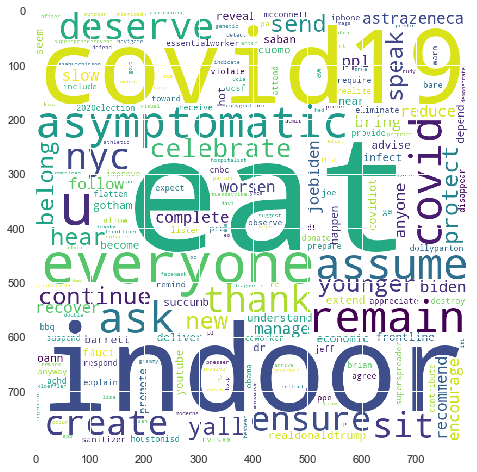

In [41]:
words_covid = list(itertools.chain(*positive_tweets['words_list'].tolist()))

counts_words = collections.Counter(words_covid)

wc = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                min_font_size = 10).generate(" ".join(counts_words)) 
                
plt.figure(figsize=(10,8))
plt.imshow(wc)

In [42]:
negative_tweets = covid_19_tweets[covid_19_tweets['sentiment_pol'] == 'negative']
negative_tweets

,Date,Tweet,User,Keyword,words_list,sentiment_pol
0,11,olganyc1211 hello fbi dhsgov id like report ac...,HereNowForever1,COVID,"[olganyc1211, hello, fbi, dhsgov, id, like, re...",negative
1,11,gilliland1tide must contest three worst disast...,profstan72,COVID,"[gilliland1tide, must, contest, three, worst, ...",negative
3,11,people told youll find one someday like whens ...,GravityOcean13,corona,"[people, told, youll, find, one, someday, like...",negative
4,11,havent seen mf covid19 fucked link,In_Jay_We_Trust,COVID,"[havent, seen, mf, covid19, fucked, link]",negative
19,11,governor dangerous fool covid19 floriduh,mo2dmax,COVID,"[governor, dangerous, fool, covid19, floriduh]",negative
...,...,...,...,...,...,...
25771,03,pay attention trusted source information covid...,Shoeshinegirl57,COVID,"[pay, attention, trusted, source, information,...",negative
25774,03,sexcounseling realdonaldtrump homeless populat...,djanko112,corona,"[sexcounseling, realdonaldtrump, homeless, pop...",negative
25776,03,wonder home delivery service affected gop covi...,Shoeshinegirl57,COVID,"[wonder, home, delivery, service, affected, go...",negative
25806,03,pastor see posse knowledge science covid19 com...,Shoeshinegirl57,COVID,"[pastor, see, posse, knowledge, science, covid...",negative


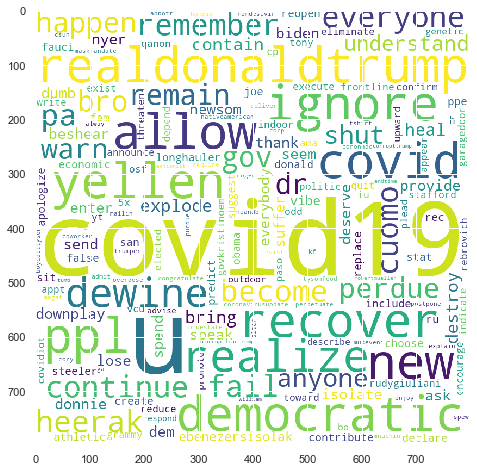

In [43]:
words_covid = list(itertools.chain(*negative_tweets['words_list'].tolist()))

counts_words = collections.Counter(words_covid)

wc = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                min_font_size = 10).generate(" ".join(counts_words)) 
                
plt.figure(figsize=(10,8))
plt.imshow(wc)

### 4.4 Use of COVID-19 vs Corona over time

In [44]:
by_keyword = covid_19_tweets_updated[['Keyword','Date']]
by_keyword = by_keyword[['Keyword','Date']].groupby(['Date','Keyword'])['Keyword'].count()
by_keyword

Date  Keyword
03    COVID      677
      corona     106
04    COVID      772
      corona      64
05    COVID      528
      corona      31
06    COVID      224
      corona      11
07    COVID      277
      corona      14
08    COVID      162
      corona       3
09    COVID      105
      corona      14
10    COVID      247
      corona       4
11    COVID      696
      corona     104
Name: Keyword, dtype: int64

In [45]:
count2 = 0
month = 2
final_vals = []
for i in range(0,len(by_keyword)):
    keyword = "Covid" if count2%2 == 0 else "corona"
    month = month + 1 if count2%2 == 0 else month
    count2 = count2 + 1
    counts = by_keyword[i]
    curr = [month,keyword,counts]
    final_vals.append(curr)
df = pd.DataFrame(final_vals, columns=['Month', 'Keyword','Count'])
# df_nonov = df[:-2]

In [46]:
# df_nonov["nov"] = 0
# df_nonov
# df_nonov.loc[16] = [11,'Covid', 19693, 1]
# df_nonov.loc[17] = [11,'corona', 2895, 1]
# df_nonov

In [129]:
fig = px.line(df, x="Month", y="Count", color="Keyword", title="Word usage per month")
fig.show()

### 4.5.1 Word2Vec
Word2Vec is a technique that is used to find the similarity between different words. It uses a base neural network to learn word embeddings. Word embeddings are representation of actual words as some numerical (vector) representation. The vectors it creates can then be mapped to some n-dimensional space. We can then use the cosine similarity between the vector representations to see how close they are together. Cosine similarity is defined over any n number of vectors within an inner product space, where n>=2. When constructing the dot product of 2 nd vectors, the cosine of the angle between them represents how parallel they are to each other. The smaller the angle, the more parallel. An angle of 0 represents parallel vectors. In this way word embeddings are mapped in space. The cosine similarity is also used to show the distance between the vectors. A lower angle means lower similarity which means less parallel vectors which implies further distance (the words are less similar). Word2Vec uses this to create a 2d graphical representation that shows the words on a plane. The distances between different words is their difference in cosine similarity. Less similar words are farther away. We can input specific words to see their similarities or pick a single word to see the most similar words to that word.



9425     [graphic, show, loved, one, best, intention, e...
6639     [foxnews, reporter, laura, ingle, called, food...
24397    [important, updatebusinessinsiderreported, fou...
20762    [im, doctor, public, health, professional, see...
1710     [lamest, thing, fast, amp, furious, movie, dri...
10810    [november, 2, 3293, 1119, pueblo, contracted, ...
3171     [together, breathehappyuk, secured, quarter, m...
14575    ore, breaking, news, overnight, beaconhealt...
6761          [watch, live, maine, cdc, covid19, briefing]
347      [realdonaldtrump, donald, come, pardon, two, t...
Name: words_list, dtype: object

In [48]:
t = time()

w2v_model = Word2Vec()
w2v_model.build_vocab(covid_19_tweets['words_list'].tolist())

print('Time to build vocab: {} mins'.format(round((time() - t) / 60, 2)))

Time to build vocab: 0.04 mins


In [49]:
w2v_model.train(covid_19_tweets['words_list'].tolist(), total_examples=w2v_model.corpus_count, epochs=30, report_delay=1)

(9692453, 12396900)

In [50]:
# w2v_model.wv.vocab

In [51]:
w2v_model.wv.most_similar(positive=["corona"])

[('lol', 0.4923291802406311),
 ('aint', 0.4709920883178711),
 ('mad', 0.45190179347991943),
 ('tho', 0.4471762478351593),
 ('lock', 0.44175809621810913),
 ('till', 0.4273790717124939),
 ('dj', 0.42181771993637085),
 ('fuckin', 0.40652960538864136),
 ('dropping', 0.4054415822029114),
 ('imma', 0.4041713774204254)]

In [52]:
w2v_model.wv.similarity('corona','covid19')

0.345868

In [53]:
def tsnescatterplot(model, word, list_names):
    """ Plot in seaborn the results from the t-SNE dimensionality reduction algorithm of the vectors of a query word,
    its list of most similar words, and a list of words.
    """
    arrays = np.empty((0, 100), dtype='f')
    word_labels = [word]
    color_list  = ['red']

    # adds the vector of the query word
    arrays = np.append(arrays, model.wv.__getitem__([word]), axis=0)
    
    # gets list of most similar words
    close_words = model.wv.most_similar([word])
    
    # adds the vector for each of the closest words to the array
    for wrd_score in close_words:
        wrd_vector = model.wv.__getitem__([wrd_score[0]])
        word_labels.append(wrd_score[0])
        color_list.append('blue')
        arrays = np.append(arrays, wrd_vector, axis=0)
    
    # adds the vector for each of the words from list_names to the array
    for wrd in list_names:
        wrd_vector = model.wv.__getitem__([wrd])
        word_labels.append(wrd)
        color_list.append('green')
        arrays = np.append(arrays, wrd_vector, axis=0)
        
    # Reduces the dimensionality from 300 to 50 dimensions with PCA
    reduc = PCA().fit_transform(arrays)
    
    # Finds t-SNE coordinates for 2 dimensions
    np.set_printoptions(suppress=True)
    
    Y = TSNE(n_components=2, random_state=0, perplexity=15).fit_transform(reduc)
    
    # Sets everything up to plot
    df = pd.DataFrame({'x': [x for x in Y[:, 0]],
                       'y': [y for y in Y[:, 1]],
                       'words': word_labels,
                       'color': color_list})
    
    fig, _ = plt.subplots()
    fig.set_size_inches(9, 9)
    
    # Basic plot
    p1 = sns.regplot(data=df,
                     x="x",
                     y="y",
                     fit_reg=False,
                     marker="o",
                     scatter_kws={'s': 40,
                                  'facecolors': df['color']
                                 }
                    )
    
    # Adds annotations one by one with a loop
    for line in range(0, df.shape[0]):
         p1.text(df["x"][line],
                 df['y'][line],
                 '  ' + df["words"][line].title(),
                 horizontalalignment='left',
                 verticalalignment='bottom', size='medium',
                 color=df['color'][line],
                 weight='normal'
                ).set_size(15)

    
    plt.xlim(Y[:, 0].min()-50, Y[:, 0].max()+50)
    plt.ylim(Y[:, 1].min()-50, Y[:, 1].max()+50)
            
    plt.title('t-SNE visualization for {}'.format(word.title()))

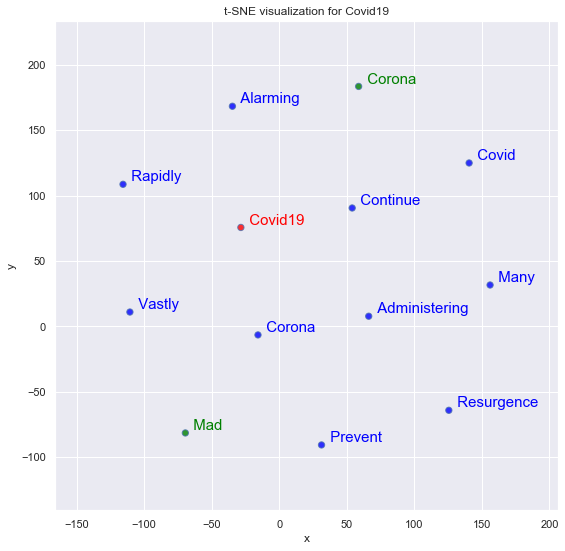

In [64]:
tsnescatterplot(w2v_model, 'covid19', ['corona', 'mad'])

We found when searching using the word ‘covid19’ other words that are similar to it. Some of these include different representations of this word that people use. ‘Covid’ and ‘Corona’ are namely among these. This makes sense as all of these words essentially mean the same thing, so they are very similar. We also see some interesting results such as ‘alarming’. As the situation of covid worsens in the US, people may use words such as ‘alarming’ to talk about how fast covid cases are rising. You might be able to predict that the situation will worsen because clearly many people use the word alarming alongside covid, which is why they are so closely linked. It would be interesting to explore different combinations of words to see how they perform.

### 4.5.2 Bigrams

In [55]:
# Create list of lists containing bigrams in tweets
terms_bigram = [list(bigrams(tweet)) for tweet in covid_19_tweets['words_list'].tolist()]

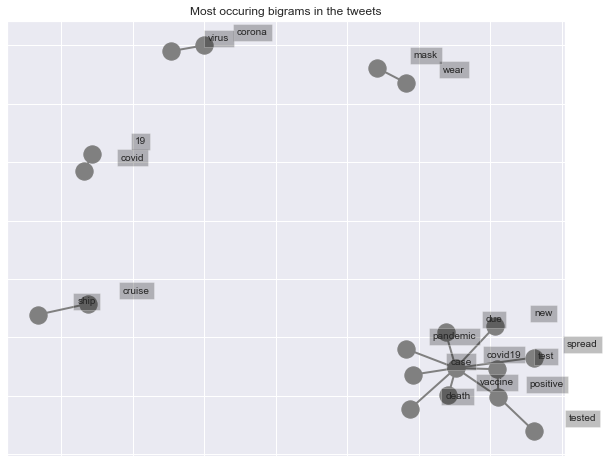

In [56]:
# Flatten list of bigrams in clean tweets
bigrams = list(itertools.chain(*terms_bigram))

# Create counter of words in clean bigrams
bigram_counts = collections.Counter(bigrams)

bigram_df = pd.DataFrame(bigram_counts.most_common(15),
                             columns=['bigram', 'count'])

# Create dictionary of bigrams and their counts
d = bigram_df.set_index('bigram').T.to_dict('records')
# Create network plot 
G = nx.Graph()

# Create connections between nodes
for k, v in d[0].items():
    G.add_edge(k[0], k[1], weight=(v * 5))

fig, ax = plt.subplots(figsize=(10, 8))

pos = nx.spring_layout(G, k=4)

# Plot networks
nx.draw_networkx(G, pos,
                 font_size=10,
                 width=2,
                 edge_color='grey',
                 node_color='gray',
                 with_labels = False,
                 ax=ax)

# Create offset labels
for key, value in pos.items():
    x, y = value[0]+.135, value[1]+.045
    ax.text(x, y,
            s=key,
            bbox=dict(facecolor='black', alpha=0.25),
            horizontalalignment='center', fontsize=10)

plt.title("Most occuring bigrams in the tweets")

plt.show()

We have also tried to use bigrams and check their similarities as this may be more useful than singular words by themselves. This will help prevent words like covid being matched with covid19 or corona. We can see some expected bigrams such as ‘corona’-‘virus’. Some more interesting bigrams may be like the ones that say ‘cruise’-‘ship’. This is likely in reference to the American cruise ship that was stuck with covid in the ocean for some time. Something else that is nice to see is the bigram ‘wear’-‘mask’. This seems good as it implies people are telling others to wear masks. However, it is not that simple. Word2Vec only takes into consideration similarity. This means people use the word ‘wear’ alongside the word ‘mask’ often, this is correlation but not necessarily causation. We cannot imply positive or negative connotation from this. For example, the tweet may be: “I hate wearing masks, I will never wear a mask!”. This tweet is clearly negative, but we cannot derive sentiment from Word2Vec. All we know is that we often see the words ‘wear’ and ‘mask’ along side each other, so they must be similar!

### 4.6 LDA
Topic modeling is used to determine different topics within some given corpus. We can determine the topics that are most talked about over all of the tweets. This is done through the Latent Dirichlet Allocation (LDA) algorithm. For the purposes of this report, we will not cover how the algorithm works. We can then visualize the topics through a python library called pyLDAvis. This allows us to see a representation of the different topics in space. Again, similar to Word2Vec, topics are spaced out based on their cosine similarity. All this means is that topics further away from each other have less in common. Words are clustered together to form different topics. Also, topics show their “weight” based on their size, the higher weighted topics are more popular than lower weighted topics. They are also numbered in order based on their weights.

In [57]:
tweets_column = covid_19_tweets['Tweet']
count_vectorizer = CountVectorizer(stop_words='english')
feature_matrix = count_vectorizer.fit_transform(tweets_column)

In [58]:
lda_model = LatentDirichletAllocation()
lda_output = lda_model.fit_transform(feature_matrix)
display(lda_output)

array([[0.00344859, 0.0034487 , 0.00344889, ..., 0.00344858, 0.00344862,
        0.96896187],
       [0.01000174, 0.0100034 , 0.01000218, ..., 0.01000202, 0.0100033 ,
        0.01000358],
       [0.00384633, 0.00384693, 0.18099099, ..., 0.00384641, 0.00384662,
        0.78823525],
       ...,
       [0.01250029, 0.01250202, 0.01250925, ..., 0.0125042 , 0.01250146,
        0.8874716 ],
       [0.01111212, 0.89998839, 0.01111203, ..., 0.01111203, 0.01111259,
        0.01111285],
       [0.00138903, 0.00138956, 0.00138916, ..., 0.00138895, 0.00138899,
        0.98749799]])

In [ ]:
display(lda_output.shape)

In the visualization, clicking on a specific topic will also show the words that are most frequent within that topic, along with the overall frequency of that word across all topics. Of course, this implies that the same word can be a part of multiple different topics, which is the case in real life. The topics themselves are not labeled. Rather, the interpreter (our team in this case) will need to see the words within a topic and then draw conclusions on what topic those words represent. This can be done with different techniques such as topic labeling through predefined dictionaries of words belonging to some topic. We have left this for a future consideration.

Viewing the most popular topic, we see words such as ‘covid’, ‘corona’, ‘virus’, and ‘death’. Of course, these words are similar, so they are classed within the same topic. These topics are not necessarily the same as the topics we have in modern English, such as ‘horror’ or ‘politics’. Rather, these are topics are made by the clustering and distance that the LDA algorithm defines. It would be interesting to try to find out exactly what these topics are or to find a way to try to cluster tweets into predefined topics. We leave this as a future consideration.

In [123]:
panel = pyLDAvis.sklearn.prepare(lda_model, feature_matrix, count_vectorizer, mds='tsne')
pyLDAvis.display(panel)

# 5. Conclusion
While we have managed to make good progress in the goals, we have set for ourselves, we did not reach the full extent of our motivated work. We hope to keep working on this project and cover the last two points (marked with *) to see our scope to fruition. Moreover, we further hope to gain access to more specific location of tweets to answer our further motivations of state-by-state analyses and the possibility of our model being used in national decision making.

# * References